# Network Reconstruction Genetic Algorithm

## 1. Imports

In [1]:
import numpy as np
import random
import networkx as nx
from scipy.linalg import expm
from tqdm import tqdm
import matplotlib.pyplot as plt
# importing the frozen network and genetic evolution classes
from network import Frozen_Network, kron
from genetic_algorithm import Genetic_Evolution

## 2. Configuration

In [2]:
pop_size = 100

#network parameters
##########################################
# number of nodes
n = 12
# each node is joined with its m nearest neighbours in a ring topology
m = 4
# probability of edge rewiring
p = 0.2

In [3]:
# Building a Watts-Strogatz network
def G(n , m , p):
    return nx.watts_strogatz_graph(n , m , p , seed = None)

In [4]:
def adjacency_matrix_target():
    return np.array(nx.to_numpy_array(target).astype("complex"))

### 2.1 Target Creation

In [5]:
target = G(n , m , p)

In [6]:
ts = 0.1
num_steps = 100
 
target = Frozen_Network(adjacency_matrix_target())
target.evolution(ts, num_steps)

### 2.2 Population Creation

In [7]:
def randomNetwork(n, m):
    return Frozen_Network(nx.to_numpy_array(G(n, m, round(random.uniform(0.0, 1.0), 2))).astype("complex"))

In [8]:
dists = []
adj_dists = []

for i in tqdm(range(1)):
    network1 = randomNetwork(n,m)
    network2 = randomNetwork(n,m)
    network1.evolution(ts, num_steps)
    network2.calculate_distance(network1.sink_data, ts, num_steps)
    network2.calculate_adjacency_distance(network1.adjacency_matrix)
    dists.append(network2.distance)
    adj_dists.append(network2.adj_distance)


100%|██████████| 1/1 [00:00<00:00, 29.84it/s]


Text(0, 0.5, 'Distance')

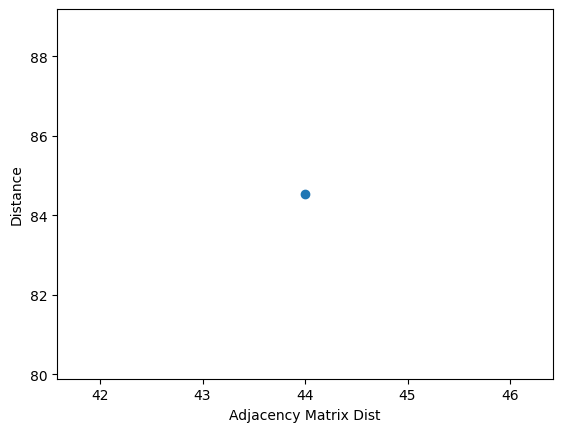

In [9]:
plt.scatter(adj_dists, dists)
plt.xlabel("Adjacency Matrix Dist")
plt.ylabel("Distance")

In [10]:
# Generating the population of networks
def pop(pop_size, n, m):
    return [Frozen_Network(nx.to_numpy_array(G(n, m, round(random.uniform(0.0, 1.0), 2))).astype("complex")) for _ in range(pop_size)]

In [11]:
import multiprocessing

def evalutate_network(network):
    network.calculate_distance(target.sink_data, ts, num_steps)
    return None

def evalutate_population(pop):
    for network in pop:
        if network.distance is None:
            evalutate_network(network)

## 3. Genetic Algorithm

In [12]:
num_iterations = 100

In [13]:
from IPython.display import clear_output

def run(iterations = 3):
    population = pop(pop_size, n, m)
    evalutate_population(population)

    distances = []
    connections = []
    fit_individual = None


    if min([network.distance for network in population]) < 1e-3:
        fit_individual = sorted(population, key = lambda x: x.distance)[0]
        print("Optimal network found")
    else:
        distances.append([network.distance for network in population])
        for i in tqdm(range(iterations)):
            
            print(f"Current best: {min(distances[-1])}, Current Average: {np.mean(distances[-1])}, Average Connections: {np.mean([network.num_connections for network in population])}")

            population = Genetic_Evolution(sorted(population, key=lambda x: x.distance)[:len(population)//2], mutation_probability=0.01).new_population()
            evalutate_population(population)
            distances.append([network.distance for network in population])
            
            if min(distances[-1]) < 10**-3:
                fit_individual = sorted(population, key = lambda x: x.distance)[0]
                print("Converged!")
                break
        else:
            print("No fit individual found within iteration limit")

    return distances, fit_individual

In [14]:
population = pop(pop_size, n, m)

In [15]:
distances, fit_individual = run(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Current best: 92.44915740052693, Current Average: 137.99555248516782, Average Connections: 24.0


  1%|          | 1/100 [00:00<01:29,  1.10it/s]

Current best: 67.45286562577255, Current Average: 129.6035576501198, Average Connections: 23.5


  2%|▏         | 2/100 [00:01<01:23,  1.17it/s]

Current best: 59.66909347645584, Current Average: 125.0264546140309, Average Connections: 23.59


  3%|▎         | 3/100 [00:02<01:22,  1.17it/s]

Current best: 59.66909347645584, Current Average: 121.95521454521945, Average Connections: 23.51


  4%|▍         | 4/100 [00:03<01:21,  1.18it/s]

Current best: 59.66909347645584, Current Average: 116.33799339981697, Average Connections: 23.11


  5%|▌         | 5/100 [00:04<01:18,  1.22it/s]

Current best: 59.66909347645584, Current Average: 115.32539186163534, Average Connections: 22.46


  6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

Current best: 59.66909347645584, Current Average: 108.10065157050117, Average Connections: 22.24


  7%|▋         | 7/100 [00:05<01:20,  1.16it/s]

Current best: 59.66909347645584, Current Average: 103.22657722262983, Average Connections: 22.08


  8%|▊         | 8/100 [00:06<01:20,  1.14it/s]

Current best: 51.44655420219573, Current Average: 95.33791364547984, Average Connections: 22.07


  9%|▉         | 9/100 [00:07<01:19,  1.15it/s]

Current best: 50.58383571135709, Current Average: 91.99953968786494, Average Connections: 21.88


 10%|█         | 10/100 [00:08<01:21,  1.10it/s]

Current best: 50.58383571135709, Current Average: 86.97864032210187, Average Connections: 21.99


 10%|█         | 10/100 [00:09<01:24,  1.07it/s]


KeyboardInterrupt: 

## 4. Results

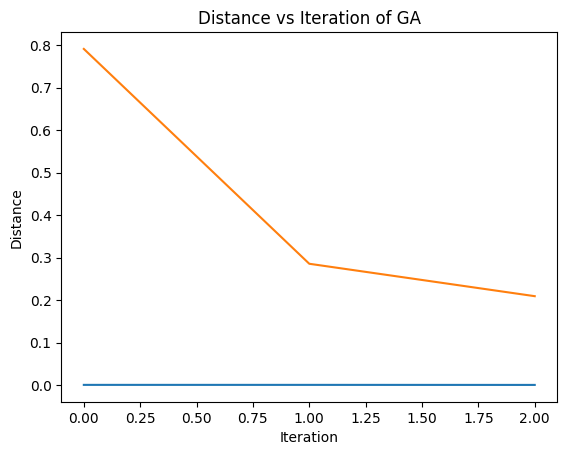

In [ ]:

# plotting the distance as a function of the number of times the algorithm is iterated
plt.plot([i for i in range(len(distances))], np.min(distances, axis=1))
plt.plot([i for i in range(len(distances))], np.average(distances, axis=1))
plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.title('Distance vs Iteration of GA')
plt.show()
